# setting up environment

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
import numpy as np

In [3]:
import re
def get_export(url):
    exp = '/edit#gid='
    start = re.search(exp, url).span()[0]
    stop = re.search(exp, url).span()[1]
    sheet_id = int(url[stop:])
    url = url[:start] + f'/export?gid={sheet_id}&format=csv'
    return url
# Replace with your modified URL
url_returns = 'https://docs.google.com/spreadsheets/d/1f8O0oFsmXPWNidNlCIvO8j5e3XtCTzld/edit#gid=126743382'
url_orders = 'https://docs.google.com/spreadsheets/d/1f8O0oFsmXPWNidNlCIvO8j5e3XtCTzld/edit#gid=955321196'
url_people = 'https://docs.google.com/spreadsheets/d/1f8O0oFsmXPWNidNlCIvO8j5e3XtCTzld/edit#gid=596536456'


orders = pd.read_csv(get_export(url_orders))
returns = pd.read_csv(get_export(url_returns))
people = pd.read_csv(get_export(url_people))


# Eda

In [4]:
# для начала посмотрим на таблицу orders
print(f'Количество дупликатов : {orders.duplicated().sum()}')
orders.info()
orders[['Sales', 'Quantity', 'Discount', 'Profit', 'Shipping Cost']].describe()

Количество дупликатов : 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Row ID          51290 non-null  int64  
 1   Order ID        51290 non-null  object 
 2   Order Date      51290 non-null  object 
 3   Ship Date       51290 non-null  object 
 4   Ship Mode       51290 non-null  object 
 5   Customer ID     51290 non-null  object 
 6   Customer Name   51290 non-null  object 
 7   Segment         51290 non-null  object 
 8   Postal Code     9994 non-null   float64
 9   City            51290 non-null  object 
 10  State           51290 non-null  object 
 11  Country         51290 non-null  object 
 12  Region          51290 non-null  object 
 13  Market          51290 non-null  object 
 14  Product ID      51290 non-null  object 
 15  Product Name    51290 non-null  object 
 16  Sub-Category    51290 non-null  object 
 17  Categ

,Sales,Quantity,Discount,Profit,Shipping Cost
count,51290.000000,51290.000000,51290.000000,51290.000000,51290.000000
mean,246.490581,3.476545,0.142908,28.610982,26.478567
std,487.565361,2.278766,0.212280,174.340972,57.251373
min,0.444000,1.000000,0.000000,-6599.978000,1.002000
25%,30.758625,2.000000,0.000000,0.000000,2.610000
50%,85.053000,3.000000,0.000000,9.240000,7.790000
75%,251.053200,5.000000,0.200000,36.810000,24.450000
max,22638.480000,14.000000,0.850000,8399.976000,933.570000


In [5]:
orders.describe(include='object')

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,Country,Region,Market,Product ID,Product Name,Sub-Category,Category,Order Priority
count,51290,51290,51290,51290,51290,51290,51290,51290,51290,51290,51290,51290,51290,51290,51290,51290,51290
unique,25728,1429,1463,4,17415,796,3,3650,1106,165,23,5,3788,3788,17,3,4
top,CA-2017-SV20365140-42999,18/6/2017,22/11/2017,Standard Class,SV-203651406,Muhammed Yedwab,Consumer,New York City,California,United States,Western Europe,Asia Pacific,OFF-FA-6129,Staples,Binders,Office Supplies,Medium
freq,14,135,130,30775,26,108,26518,915,2001,9994,5883,14302,227,227,6146,31289,29433


In [6]:
years = orders['Order Date'].apply(lambda x : x.split('/')[2])
years.value_counts()

Order Date
2017    17531
2016    13799
2015    10962
2014     8998
Name: count, dtype: int64

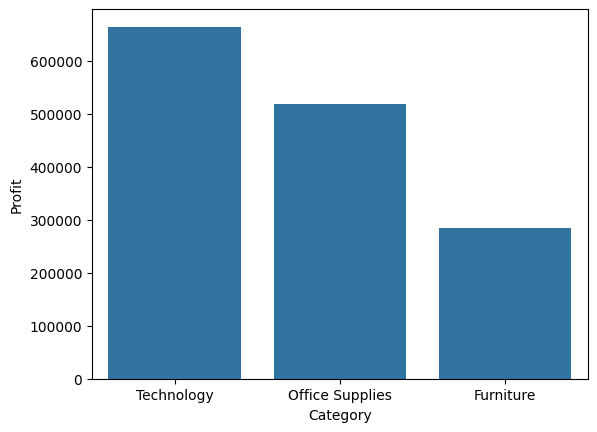

In [7]:
data = orders[['Category', 'Profit', 'Sales']].groupby('Category').aggregate('sum').sort_values('Profit', ascending=False)
sns.barplot(x='Category', y='Profit', data=data)
plt.show()

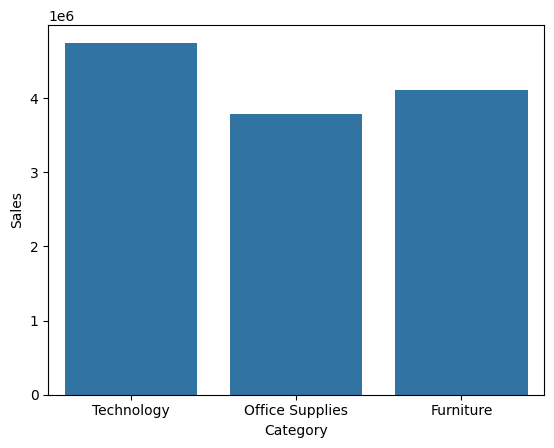

In [8]:
sns.barplot(x='Category', y='Sales', data=data)
plt.show()

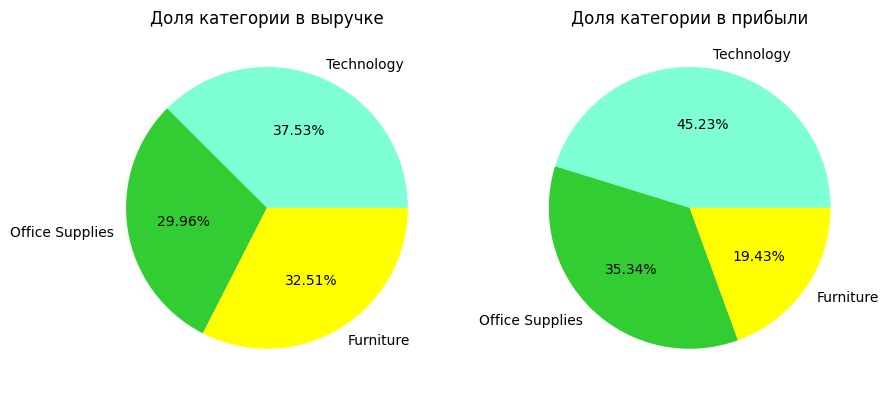

In [9]:
fig, (ax_sales, ax_profit) = plt.subplots(1, 2, figsize=(10, 10))
colors = ['aquamarine', 'limegreen', 'yellow']
ax_profit.pie(x=data.Profit, labels=data.index, autopct='%.2f%%', colors=colors)
ax_sales.pie(x=data.Sales, labels=data.index, autopct='%.2f%%', colors=colors)
ax_profit.set_title('Доля категории в прибыли')
ax_sales.set_title('Доля категории в выручке')
plt.show()

Как мы видим, распределение выручки категориям примерно одинаковое. Вместе с тем, офисные товары и техника оказываются более прибыльными, чем мебель: их доля в прибыли больше, чем доля в выручке, а у мебели - наоборот, меньше. Наиболее прибыльная категория - technology, она же приносит наибольную выручку

0 Furniture
1 Office Supplies
2 Technology


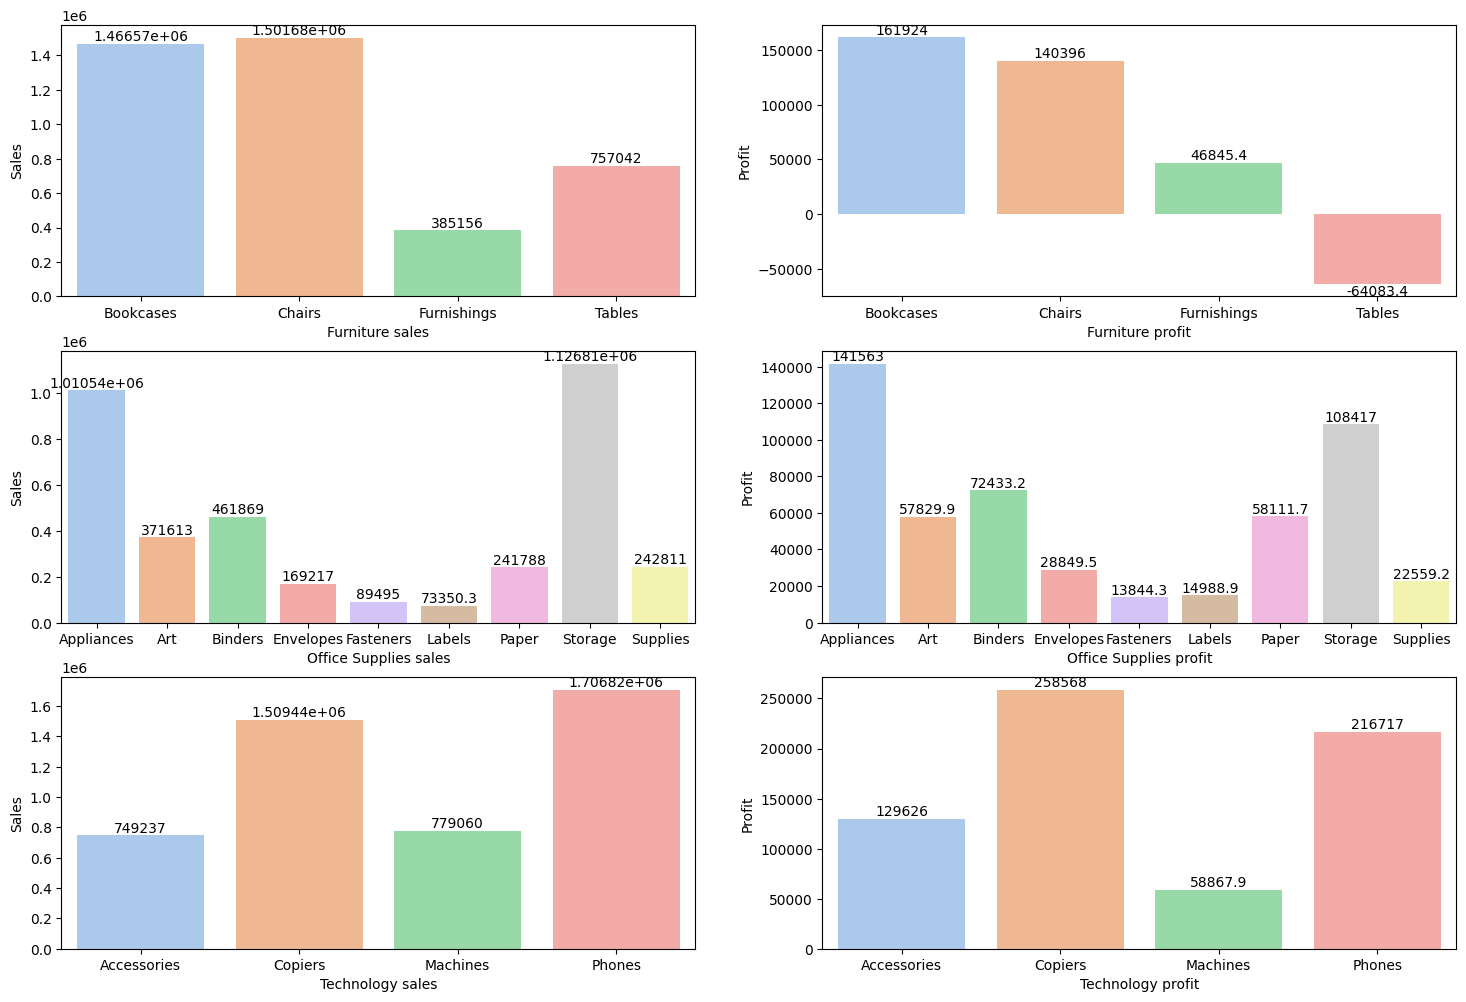

In [10]:
# теперь посмотрим по подкатегориям

def show_subcategories(f:str, relative=False):
  fig, axes = plt.subplots(len(orders.Category.unique()), 2, figsize=(18, 12))
  for i, category in enumerate(orders.Category.unique()):
    print(i, category)
    data = orders[['Sub-Category', 'Sales', 'Profit']][orders.Category == category].groupby('Sub-Category').aggregate(f)
    if relative:
      data['Profit'] = data.Profit / data.Sales
    n = len(data.index.unique())
    sns.barplot(x='Sub-Category', hue='Sub-Category', y='Sales', data=data, palette=sns.color_palette("pastel", n), ax=axes[i][0])
    sns.barplot(x='Sub-Category', hue='Sub-Category', y='Profit', data=data, palette=sns.color_palette("pastel", n), ax=axes[i][1])
    for j in 0, 1:
      for container in axes[i][j].containers:
        axes[i][j].bar_label(container)
    axes[i][0].set_xlabel(f'{category} sales')
    axes[i][1].set_xlabel(f'{category} profit')

  plt.show()
show_subcategories('sum')

0 Furniture
1 Office Supplies
2 Technology


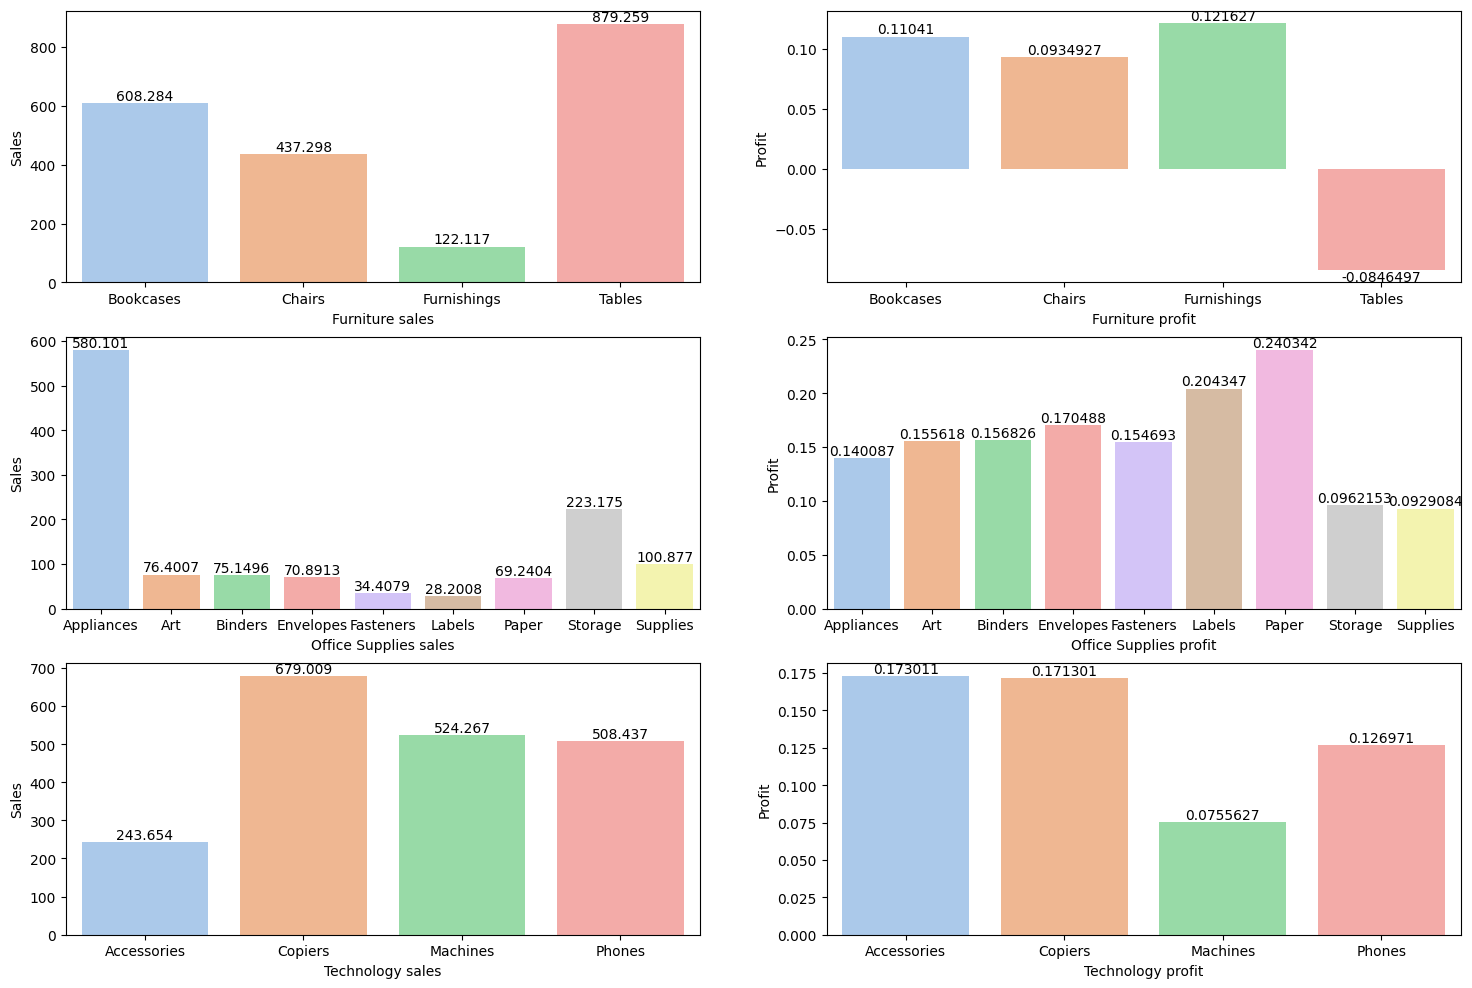

In [11]:
# то же самое только со средним
show_subcategories('mean', relative=True)

Наибольшую выручку компании приносят телефоны, стулья, книжные шкафы и копировальные машины, бытовая техника. Они же являеются наиболее значимыми по получаемой прибыли. Здесь же замечаем, что продажа столов является убыточной для магазина - она потеряла 64 тысячи долларов на этой категории мебели, в среднем примерно по 8% с каждого проданного стола.

Однако наиболее прибыльными (по отношению прибыли к цене товара) являются именно офисные товары - бирки (labels, ~20%) и бумага (paper, ~24%). Также оказывается выгодно продавать конверты, копировальные машины и аксессуары (17%) и другие офисные товары - art, binders, fasteners. А вот телефоны, которые были в топе по выручке, оказываются далеко не самыми прибыльными - 12%.


по-хорошему здесь было бы нужно посчитать рентабельность - отношение себестоимости и прибыли, но таких данных к сожалению нету, поэтому мы сравниваем прибыльность подкатегорий по отношению прибыли и цены продажи (предполагая, что цена продажи неплохо коррелирует с себестоимостью)

In [12]:
region_sales = orders[['Sales', 'Region']].groupby('Region', as_index=False).sum().sort_values('Sales', ascending=False).reset_index(drop=True)
region_sales

,Region,Sales
0,Western Europe,1.731930e+06
1,Central America,1.223101e+06
2,Oceania,1.100185e+06
3,Southeastern Asia,8.844232e+05
4,Southern Asia,8.665727e+05
5,Eastern Asia,8.550594e+05
6,Western US,7.254578e+05
7,Eastern US,6.787812e+05
8,Northern Europe,6.367792e+05
9,South America,6.172237e+05


<Axes: xlabel='Sales', ylabel='Region'>

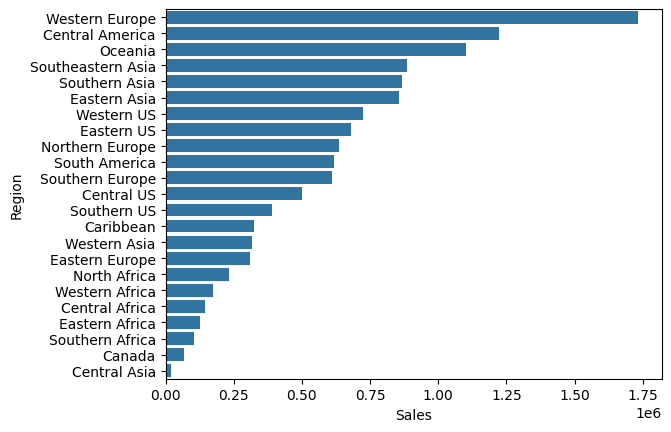

In [13]:
sns.barplot(y='Region', x='Sales', data=region_sales)

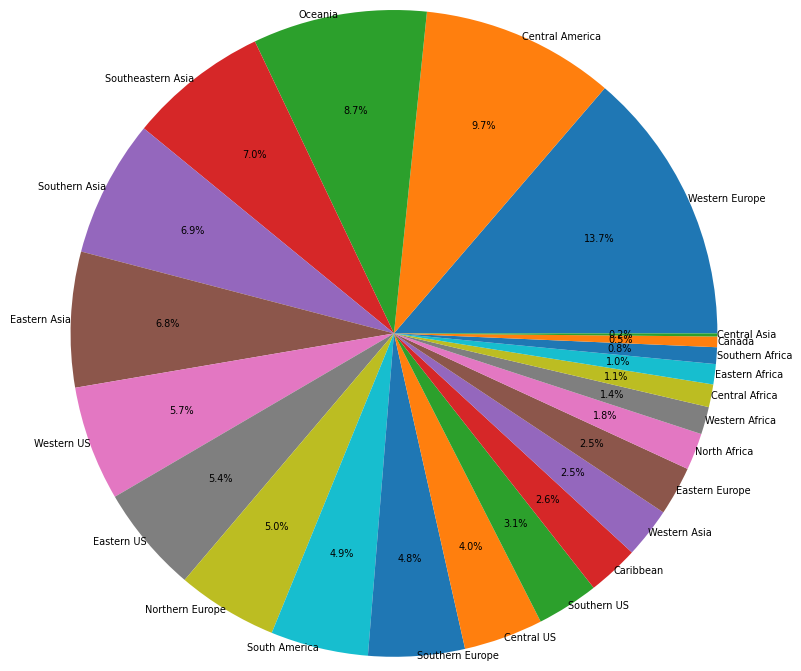

In [14]:
plt.figure(figsize=(7, 7))
plt.pie(region_sales.Sales, labels=region_sales.Region, autopct='%.1f%%', labeldistance=1, pctdistance=0.7, radius=1.5, textprops={'fontsize': 7})

plt.show()

Выходит, что наибольшую выручку приносят продажи в Западной Европе, Центральной Америке и Океании. Однако нужно учитывать, что здесь US и Европа поделены на много разных регионов, а сравниваются они с более крупными группами стран. Учтем этот факт и посчитаем долю продаж именно в США

In [15]:
parts_of_us = [i for i in region_sales.Region.unique() if 'US' in i]
us_sales = region_sales.loc[region_sales.Region.isin(parts_of_us)].sum(numeric_only=True).iloc[0]
world_sales = region_sales.sum(numeric_only=True).iloc[0]
print(f'{us_sales = }')
print(f'{world_sales = }')
print(f'Доля прибыли в США равна {round(us_sales / world_sales, 2)}')

us_sales = 2297200.8603
world_sales = 12642501.909880001
Доля прибыли в США равна 0.18


Как видим, на самом деле США довольно значимый рынок, приносящий компании почти пятую часть дохода.

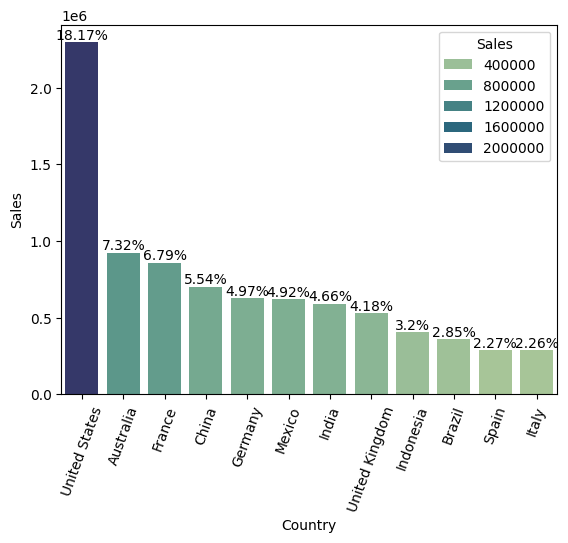

In [16]:
n = 12
country_sales = orders[['Country', 'Sales']].groupby('Country').agg('sum').sort_values('Sales', ascending=False).head(n=n)
fig, ax = plt.subplots()
sns.barplot(x='Country', y='Sales', hue='Sales', data=country_sales, palette=sns.color_palette('crest', as_cmap=True))
plt.xticks(rotation=70)
for i in range(len(ax.containers)):
  plt.bar_label(ax.containers[i], labels=[str(round(country_sales.iloc[n - i - 1]['Sales'] / world_sales, 4) * 100) + '%'])
plt.show()

Получается, основные рынки - это западные страны, включая Европу, Америку, Австралию. Страны Азии, такие как Индия, Китай и Индонезия, занимают меньшую долю в выручке, особенно если принять во внимание размеры экономик этих стран и их население.

In [17]:
def calc_returns(order_returns:pd.DataFrame) -> pd.DataFrame:
  order_returns['Returned'] = order_returns.Returned.apply(lambda x : 1 if x == 'Yes' else 0)
  order_returns['Quarter'] = order_returns['Order Date'].apply(lambda x : (int(x.split('/')[1]) + 2) // 3)
  quarter_returns = order_returns.groupby('Quarter').agg({
      'Returned' : ['sum', 'count']
  })
  quarter_returns[('Returned', 'Share')] = round(quarter_returns[('Returned',   'sum')] / quarter_returns[('Returned',   'count')] * 100, 2)
  return quarter_returns
order_returns = orders[['Order ID', 'Order Date', 'Country']].merge(returns[['Order ID', 'Returned']], on='Order ID', how='left')
world_returns_stats = calc_returns(order_returns)
world_returns_stats

Returned              
             sum  count  Share
Quarter                       
1            988   7905  12.50
2           1277  12168  10.49
3           1621  14289  11.34
4           2169  17231  12.59

In [18]:
def check_us(row):
  if 'US' in row['Region']: return True
  return False
m = returns.apply(check_us, axis=1)
us_returns = returns[['Order ID', 'Returned', 'Region']][m]
us_order_returns = orders[['Order ID', 'Order Date', 'Country']][orders.Country == "United States"].merge(us_returns, on='Order ID', how='left')
us_returns_stats = calc_returns(us_order_returns)
us_returns_stats

Returned             
             sum count  Share
Quarter                      
1            168  1385  12.13
2            285  2145  13.29
3            360  2823  12.75
4            453  3725  12.16

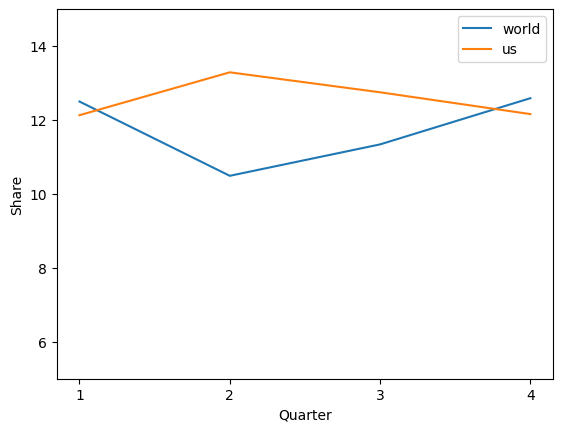

In [19]:
fig, ax = plt.subplots()
ax.xaxis.get_major_locator().set_params(integer=True)
ax.set_ylim((5, 15))
sns.lineplot(x=world_returns_stats.index, y=world_returns_stats[('Returned', 'Share')], ax=ax, label='world')
sns.lineplot(x=us_returns_stats.index, y=us_returns_stats[('Returned', 'Share')], ax=ax, label='us')
ax.set_ylabel('Share')
plt.show()

Доля возвратов по всему миру максимальна в 1 и 4 кварталах, минимальная - во втором квартале. В Соединенных штатах наблюдается противоположная ситуация: максимальная доля возврат во втором квартале, а минимальная в 1 и 4.
Можно заметить, что в среднем доля возврат во США выше, чем по остальному миру. Можно предположить, что дело в том, что США - развитая страна, стандарты качества там выше, чем в среднем по миру, а рынок насыщен большим количеством близких субститутов. Поэтому если потребителю не подошла по тем или иным причинам заказанная вещь, он более вероятно вернет ее.

Чтобы проверить эту гипотезу, нужно сравнить доли возврат по другим развитым странам

In [20]:
developed_countries = [
    'France',
    'Germany',
    'Australia',
    'Canada'
]
order_returns
stats_by_country = order_returns.groupby('Country').agg({'Returned': ['sum', 'count']})
stats_by_country['Share'] = stats_by_country[('Returned', 'sum')] / stats_by_country[('Returned', 'count')]
m = stats_by_country.apply(lambda x : True if x.name in developed_countries else False, axis=1)
stats_by_country[m]

Returned           Share
               sum count          
Country                           
Australia      307  2839  0.108137
Canada          36   384  0.093750
France         288  2839  0.101444
Germany        221  2072  0.106660

In [21]:
# делаем ограничение на >= 200 заказов, чтобы не учитывать маленькие страны где мало заказов и мало возвратов
stats_by_country[stats_by_country[('Returned', 'count')] >= 200].sort_values('Share', ascending=False).head(n=10)

Returned           Share
                  sum count          
Country                              
Vietnam            50   263  0.190114
Philippines       126   700  0.180000
Morocco            72   455  0.158242
Saudi Arabia       58   369  0.157182
Guatemala          81   539  0.150278
New Zealand        94   628  0.149682
Netherlands        63   441  0.142857
Pakistan           34   249  0.136546
Turkey            186  1388  0.134006
Thailand           39   295  0.132203

Получается, наше объяснение неверно: в остальных развитых странах процент возвратов ниже, чем в США, и даже ниже чем в среднем по миру. Поэтому изначальная гипотеза не является верной. Наоборот, оказывается, что больше всего возвратов в азиатских странах, а не в Европе или Америке. Это может быть связано с разными факторами - например, с привычками покупателей примерить вещь перед покупкой, или же с маркетинговыми стратегиями в этом регионе (например, большое количество агрессивной рекламы приводит к большому количеству спонтанных покупок и, как следствие, к большому количеству возвратов), или же с тем, что эти страны в среднем беднее стран Запада, поэтому людям приходится более ответственно подходить к своим расходам и не покупать лишнего. Проверим последнюю гипотезу - выясним, какая корреляция между возвратами и богатством страны. В качестве показателя богатства возьмем ВВП по ППС на душу населения за 2014 год, потому что заказы были сделаны в период с 2014 по 2017

In [22]:
gdp_data = pd.read_excel('https://api.worldbank.org/v2/en/indicator/NY.GDP.PCAP.PP.CD?downloadformat=excel', skiprows=2, header=1)
gpd_data = gdp_data[['Country Name', '2014']].dropna().reset_index()
gdp_data.rename(columns={'Country Name' : 'Country'}, inplace=True)


In [23]:
gdp_data = gdp_data[['Country', '2014']].dropna().reset_index(drop=True)
return_data = pd.DataFrame(columns=['Share'])
return_data['Share'] = stats_by_country.Share
df = return_data.reset_index().merge(gdp_data, on='Country')
df.corr(numeric_only=True)

,Share,2014
Share,1.0000,-0.0803
2014,-0.0803,1.0000


А это предположение подтвеждается: доля возвратов и ВВП на душу населения имеют небольшую отрицательную корреляцию, то есть чем богаче страна, тем меньше возвратов.

In [24]:
#повторные заказы - когда тот же покупатель купил тот же товар еще раз
print(f'Количество повторных заказов равно')
num_repeat = orders[['Customer ID', 'Product ID']].duplicated().sum()
print(num_repeat)
print('Доля повторных заказов равна')
print(num_repeat / orders.shape[0])




Количество повторных заказов равно
118
Доля повторных заказов равна
0.002300643400272958


Учитывая категории товаров (бытовая техника, мебель, телефоны) логично, что процент повторных заказов очень маленький - мало кому нужно два одинаковых холодильника или телефона

In [25]:
# развернем две этих колонки, чтобы можно было отсортировать все заказы по времени, чтобы найти первый заказ для каждого покупателя
orders['Order Date'] = orders['Order Date'].apply(lambda x : '/'.join(x.split('/')[::-1]))
orders['Order ID'] = orders['Order ID'].apply(lambda x : '-'.join(x.split('-')[::-1]))
# orders

In [26]:
# теперь заказы отсортированы от первого к последнему
orders.sort_values('Order ID', ascending=True, inplace=True)

In [27]:
# распределение прибыли между старыми и новыми клиентами
mask = orders[['Customer ID']].duplicated() # Так как заказы отсортированы по возрастанию, дубликаты в колонке Customer ID - это все не первые заказы
print('Доля новых клиентов в прибыли равна')
value = orders.Profit[mask].sum() / orders.Profit.sum()
print(value)

Доля новых клиентов в прибыли равна
0.6769008672229003


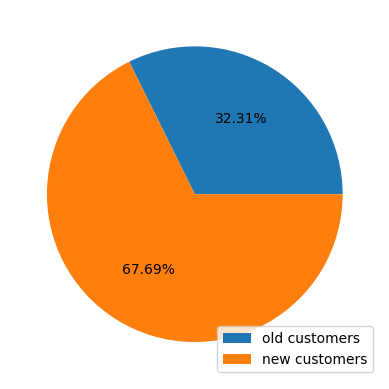

In [28]:
profit_distribution = pd.DataFrame()
profit_distribution['kind'] = ['old', 'new']
profit_distribution['share in profit'] = [1 - value, value]
plt.pie(profit_distribution['share in profit'], autopct='%.2f%%')
plt.legend(['old customers', 'new customers'])
plt.show()

# Time series analytics - graphics



In [29]:
# separate columns for: year, month, day
orders['Day'], orders['Month'], orders['Year'] = [orders['Ship Date'].apply(lambda x : '/'.join(reversed(x.split('/')[i:]))) for i in range(3)]

/var/folders/3q/37b0tth55xxdfn82hcm7ylp80000gn/T/ipykernel_34845/25829619.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  orders[p] = pd.to_datetime(orders[p])


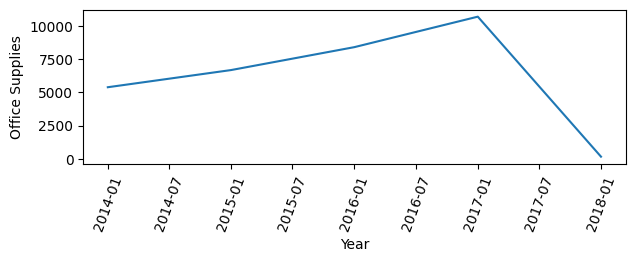

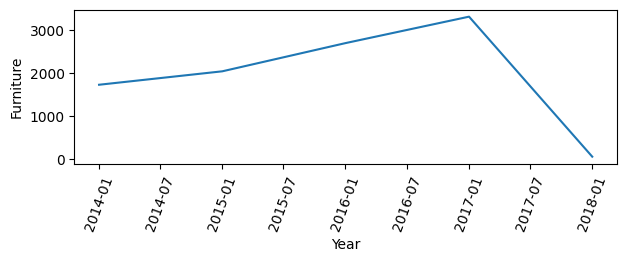

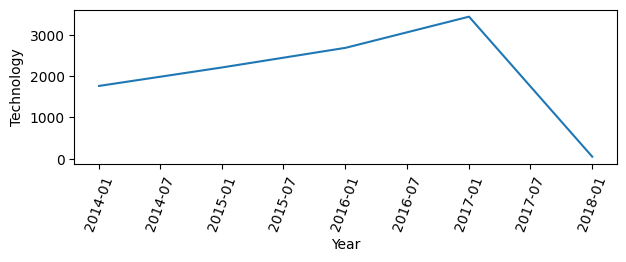

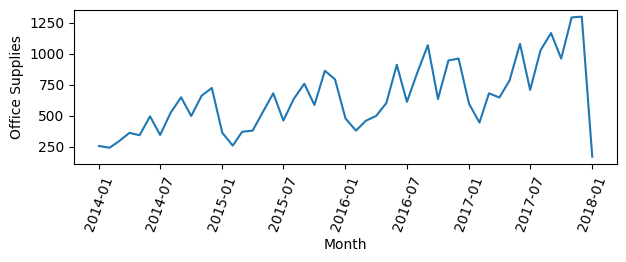

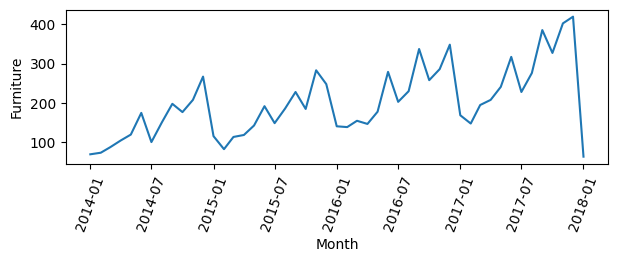

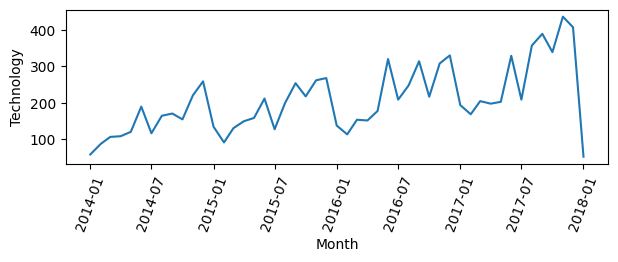

In [30]:
from matplotlib.ticker import MaxNLocator
categories = orders['Category'].unique()
periods = ['Year', 'Month', 'Day']
for p in periods:
  orders[p] = pd.to_datetime(orders[p])
for p in ['Year', 'Month']:
  for c in categories:
    plt.figure(figsize=(7, 2))
    plt.xticks(rotation=70)
    data = orders[[p, 'Category']]
    grouped = data[data.Category == c].groupby(p, as_index=False).agg(func='count').sort_values(p)
    sns.lineplot(x=p, y='Category', data=grouped)
    plt.ylabel(c)

Виден четкий восходящий тренд - в каждом следующем году в каждой категории количество продаж больше, чем в предыдущем

Однако достаточно велико влияние сезонности, продажи сильно меняются от месяца к месяцу. Например, можно заметить, что каждый февраль число продаж по всем категориям достигает локального минимума

# Train-test split

In [45]:
orders['Order Date'] = pd.to_datetime(orders['Order Date'])
data = orders[['Quantity', 'Order Date']]


In [ ]:
data = data.resample('W', on='Order Date').agg('sum')

In [47]:
data

,Quantity
Order Date,
2014-01-05,144
2014-01-12,349
2014-01-19,317
2014-01-26,440
2014-02-02,353
...,...
2017-12-03,2045
2017-12-10,1655
2017-12-17,1560


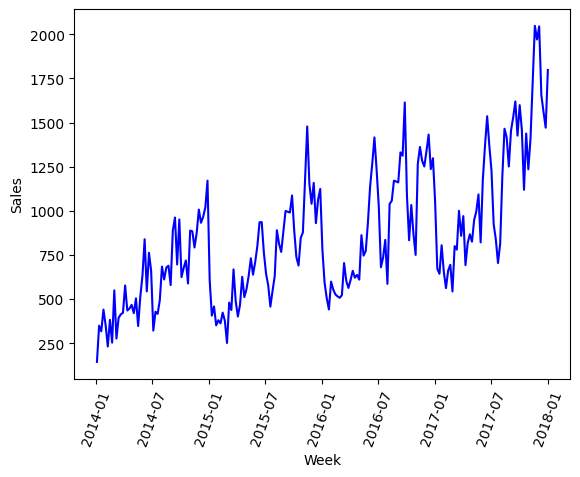

In [52]:
plt.plot(data, color='b')
plt.xticks(rotation=70)
plt.xlabel("Week")
plt.ylabel("Sales")
plt.show()

# TSA - ARIMA

In [34]:
# !pip install statsmodels
from sktime.forecasting.arima import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [44]:
p_value = adfuller(data)[1]
if p_value <= 0.05:
  print("stationary row -> can use ARIMA model")
else:
  print('non-stationary')


non-stationary


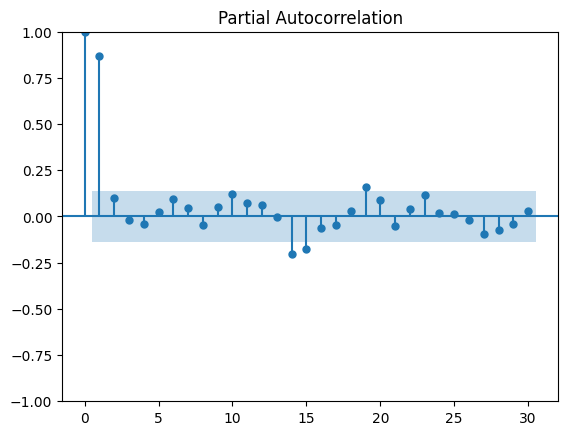

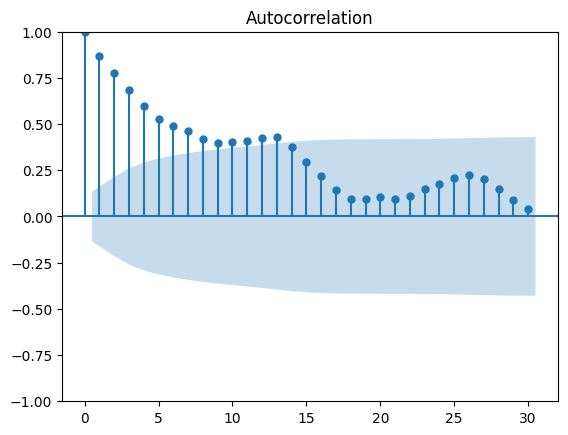

In [55]:
plot_pacf(data.values,lags=30)
plot_acf(data.values,lags=30)
plt.show()

In [79]:
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.model_selection import SlidingWindowSplitter, ForecastingGridSearchCV
from sktime.forecasting.base import ForecastingHorizon


fh = ForecastingHorizon(1)

cv = SlidingWindowSplitter(start_with_window=True, fh=fh, step_length=10, window_length=50)
forecaster = ARIMA(enforce_invertibility=False, enforce_stationarity=False, suppress_warnings=True)
arima_orders = []
start_p, start_q, start_d = 1, 1, 0
max_p = 14
max_q = 2
max_d = 1
for p in range(start_p, max_p+1):
    for q in range(start_q, max_q+1):
        for d in range(start_d, max_d + 1):
            if set([p, q]) != set([6, 7]):
                arima_orders.append((p, d, q))
param_grid = {"order": arima_orders}

In [80]:
grid_searcher = ForecastingGridSearchCV(
    forecaster=forecaster,
    cv=cv,
    param_grid=param_grid,
    error_score='raise',
    backend="multiprocessing"
)
data.fillna(0, inplace=True)
grid_searcher.fit(data)

ForecastingGridSearchCV(backend='multiprocessing',
                        cv=SlidingWindowSplitter(fh=ForecastingHorizon([1], dtype='int64', is_relative=True),
                                                 step_length=10,
                                                 window_length=50),
                        error_score='raise',
                        forecaster=ARIMA(enforce_invertibility=False,
                                         enforce_stationarity=False,
                                         suppress_warnings=True),
                        param_grid={'order': [(1, 0, 1), (1, 1, 1), (1, 0, 2),
                                              (1, 1, 2), (2, 0, 1), (2, 1, 1),
                                              (2, 0, 2), (2, 1, 2), (3, 0, 1),
                                              (3, 1, 1), (3, 0, 2), (3, 1, 2),
                                              (4, 0, 1), (4, 1, 1), (4, 0, 2),
                                              (4, 1, 2), (5, 0, 1), (5, 1, 1),
                                              (5, 0, 2), (5, 1, 2), (6, 0, 1),
                                              (6, 1, 1), (6, 0, 2), (6, 1, 2),
                                              (7, 0, 1), (7, 1, 1), (7, 0, 2),
                                              (7, 1, 2), (8, 0, 1), (8, 1, 1), ...]})

In [81]:
grid_searcher.best_forecaster_.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  209
Model:               SARIMAX(7, 0, 2)   Log Likelihood               -1323.177
Date:                Sun, 02 Mar 2025   AIC                           2668.353
Time:                        12:56:05   BIC                           2704.744
Sample:                    01-05-2014   HQIC                          2683.077
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     57.9771     66.942      0.866      0.386     -73.227     189.182
ar.L1          0.4283      0.414      1.036      0.300      -0.382       1.239
ar.L2          0.7396      0.284      2.604      0.009       0.183       1.296
ar.L3         -0.2224      0.310     -0.717      0.473      -0.830       0.385
ar.L4         -0.1584      0.108     -1.469      0.142      -0.370       0.053
ar.L5         -0.0821      0.120     -0.686      0.493      -0.317       0.152
ar.L6          0.1285      0.079      1.637      0.102      -0.025       0.282
ar.L7          0.1150      0.105      1.092      0.275      -0.091       0.321
ma.L1          0.3879      0.421      0.922      0.357      -0.437       1.213
ma.L2         -0.3573      0.337     -1.062      0.288      -1.017       0.302
sigma2      2.888e+04   3277.965      8.810      0.000    2.25e+04    3.53e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.95
Prob(Q):                              0.95   Prob(JB):                         0.62
Heteroskedasticity (H):               1.75   Skew:                            -0.10
Prob(H) (two-sided):                  0.02   Kurtosis:                         2.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [82]:
grid_searcher.cv_results_.iloc[29]

mean_test_MeanAbsolutePercentageError                0.152775
mean_fit_time                                        0.126847
mean_pred_time                                       0.008503
params                                   {'order': (8, 1, 1)}
rank_test_MeanAbsolutePercentageError                     2.0
Name: 29, dtype: object